In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import roc_curve, auc
from rdkit import Chem


matplotlib.rcdefaults()
sns.set_style("darkgrid")
plt.rcParams["figure.dpi"] = 100

pd.set_option("display.max_columns", None)

In [2]:
# title suffix
title_suffix = "GPR40"

# Files we are processing
file_path_sdf_active = "./GPR40/docking/GPR40_active_docking_lib_sorted.sdf"
file_path_sdf_decoy = "./GPR40/docking/GPR40_decoy_docking_lib_sorted.sdf"
file_path_strain_active = "./GPR40/strain/GPR40_active_docking_lib_sorted.csv"
file_path_strain_decoy = "./GPR40/strain/GPR40_decoy_docking_lib_sorted.csv"

In [3]:
import matplotx

plt.style.use(matplotx.styles.tokyo_night["storm"])

In [4]:
def sdf_to_df(args):
    """
    Load molecules and their properties from an SDF file into a DataFrame.

    Example usage: df=sdf_to_df(("./ADRB1/docking/ADRB1_active_docking_lib.sdf", "active"))

    Note that this function was originally intended to be used with the `multiprocessing` module, so the arguments are passed as a tuple.

    Will likely be updated later.

    """
    file, active_status = args  # Unpack the tuple of arguments

    # Create a molecule supplier
    mol_supplier = Chem.MultithreadedSDMolSupplier(file, numWriterThreads=8)

    # Load the molecules and their properties into a list
    molecules = []
    first_mol = True
    for mol in mol_supplier:
        if mol is not None:
            if first_mol:
                # Get properties as dictionary only for the first molecule
                props = mol.GetPropsAsDict()
                keys = props.keys()
                first_mol = False
            else:
                # For the rest of the molecules, get properties directly
                props = {key: mol.GetProp(key) for key in keys if mol.HasProp(key)}

            props["Title"] = mol.GetProp("_Name")
            props["Mol"] = mol
            props["Activity"] = 1 if active_status == "active" else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ["Title", "Mol", "Activity"] + [
        col for col in df.columns if col not in ["Title", "Mol", "Activity"]
    ]
    df = df[cols]
    df = df.rename(columns={"Title": "Molecule_Name"})

    # Convert 'r_i_docking_score' to numeric, coercing errors to NaN
    df["r_i_docking_score"] = pd.to_numeric(df["r_i_docking_score"], errors="coerce")

    # Print 'Molecule_Name' and 'r_i_docking_score' for entries that could not be converted
    non_convertible_entries = df[df["r_i_docking_score"].isna()]
    for _, row in non_convertible_entries.iterrows():
        print(
            f"Molecule_Name: {row['Molecule_Name']}, r_i_docking_score: {row['r_i_docking_score']}"
        )

    # Drop rows with non-convertible 'r_i_docking_score'
    df = df.dropna(subset=["r_i_docking_score"])

    # Convert 'r_i_docking_score' to int64
    df["r_i_docking_score"] = df["r_i_docking_score"].astype("float64")

    return df

In [5]:
active_sdf = sdf_to_df((file_path_sdf_active, "active"))
decoy_sdf = sdf_to_df((file_path_sdf_decoy, "inactive"))

In [6]:
#TODO replace with a check for duplicates and sys exit with message
duplicates_actives = active_sdf["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_sdf["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [7]:
# from old code, probably fine but not optimal
def concatenate_csv_files(file_list):
    """
    Concatenates multiple strain CSV files into a single dataframe.
    Only the first five columns are kept for now.

    Args:
        file_list (list): A list of file paths to the CSV files.

    Returns:
        pandas.DataFrame: The concatenated dataframe.

    """
    # Specify the column names
    column_names = [
        "Molecule_Name",
        "Total_E",
        "Lower_Bound",
        "Upper_Bound",
        "Num_Torsion_Patterns",
    ]

    # List to hold dataframes
    df_list = []

    # Loop over each file in the list
    for file in file_list:
        # Import the CSV file as a df, using only the first five columns of the CSV file
        df = pd.read_csv(file, usecols=range(5), names=column_names, header=0)
        df_list.append(df)

    # Concatenate all dataframes in the list
    final_df = pd.concat(df_list, ignore_index=True)

    return final_df

In [8]:
active_strain = concatenate_csv_files([file_path_strain_active])
decoy_strain = concatenate_csv_files([file_path_strain_decoy])

In [9]:
#TODO replace with a check for duplicates and sys exit with message
duplicates_actives = active_strain["Molecule_Name"].duplicated()
print(any(duplicates_actives))
duplicates_decoys = decoy_strain["Molecule_Name"].duplicated()
print(any(duplicates_decoys))

False
False


In [10]:
# only keep as commented for debug
# pre_merge = [active_sdf, decoy_sdf, active_strain, decoy_strain]

# for df in pre_merge:
#     print(df.shape)

In [11]:
active_data=pd.merge(active_sdf, active_strain, on='Molecule_Name')
decoy_data=pd.merge(decoy_sdf, decoy_strain, on='Molecule_Name')

In [12]:
# #only keep as commented for debug
# post_merge = [active_data, decoy_data]

# for df in post_merge:
#     print(df.shape)

In [13]:
all_data = pd.concat([active_data, decoy_data])

#print(all_data.shape)

In [14]:
def plot_density(df, title_suffix):
  # Hardcoded column names
  activity_col = 'Activity'
  score_col = 'r_i_docking_score'

  # Create a density plot for the score of active and inactive molecules
  sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label='Inactive', fill=True)
  sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label='Active', fill=True)

  # Add title and labels
  plt.title(f'Density Plot of Docking Score for Active and Decoy Molecules ({title_suffix})')
  plt.xlabel('Docking Score')
  plt.ylabel('Density')
  plt.legend(loc='best')

  # Show the plot
  plt.show()

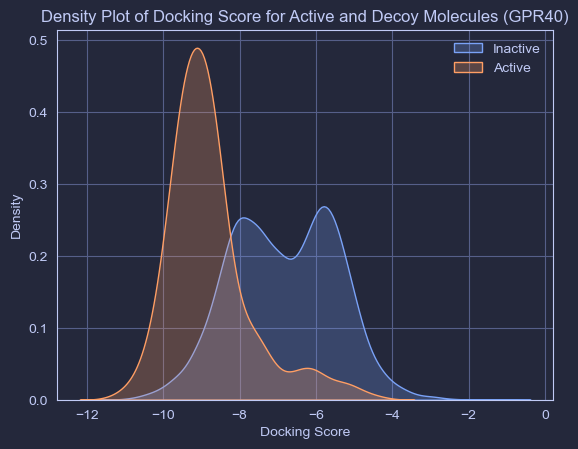

In [15]:
plot_density(all_data, title_suffix)

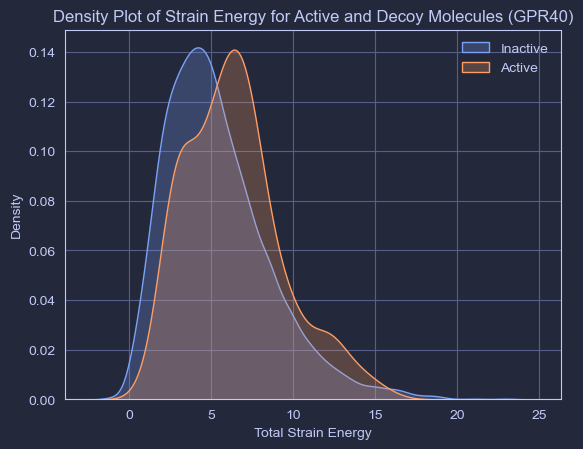

In [16]:
def plot_density_strain(df, title_suffix):
    # Hardcoded column names
    activity_col = "Activity"
    score_col = "Total_E"

    # Create a density plot for the score of active and inactive molecules
    sns.kdeplot(df.loc[df[activity_col] == 0, score_col], label="Inactive", fill=True)
    sns.kdeplot(df.loc[df[activity_col] == 1, score_col], label="Active", fill=True)

    # Add title and labels
    plt.title(
        f"Density Plot of Strain Energy for Active and Decoy Molecules ({title_suffix})"
    )
    plt.xlabel("Total Strain Energy")
    plt.ylabel("Density")
    plt.legend(loc="best")

    # Show the plot
    plt.show()

plot_density_strain(all_data, title_suffix)

In [17]:
def calculate_enrichment_parameters(df):
    """
    Calculates parameters we will need for Enrichment Plots

    Parameters:
    df (pandas.DataFrame): The dataframe to calculate the logAUC for.

    Returns:
    pandas.DataFrame: The dataframe with the logAUC calculated.
    """
    # Sort the subset by 'r_i_docking_score' in ascending order

    df = df.copy()

    df.sort_values(by="r_i_docking_score", inplace=True)

    # Reset the index so that we are ranking by the docking score
    df.reset_index(drop=True, inplace=True)

    # Adjusting the index to start from 1
    df.index += 1

    # Calculate the cumulative sum of active compounds
    df["Cumulative_Actives"] = df["Activity"].cumsum()

    # Calculate the Total Actives
    df["Total_Actives"] = df["Activity"].sum()

    # Calculate the fraction of identified actives at each row
    df["Fraction_Actives"] = df["Cumulative_Actives"] / df["Total_Actives"]

    # Calculate the percentage of compounds screened at each row
    df["Percentage_Screened"] = df.index / len(df)

    return df

In [18]:
all_data = calculate_enrichment_parameters(all_data)
all_data

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened
1,C03095174_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2894055b0>,0,GPR40_chembl19_set_decoy_sc.smi,8178,53161,0,S-OPLS,57.1172,1,C03095174_Isomer1-1,GPR40,8177,6,-11.17170,-0.37239,-1.1571,-2.53833,-11.1717,-4.5256,-0.479901,-0,-3.22389,-45.9457,-6.19778,0.368657,-0.0840014,-94.3056,-52.1435,18.5623,126,47,0,11.220968,7.912696,NaN,0.0,0,244,0.000000,0.000114
2,TAK-875_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x16fcee7a0>,1,GPR40_chembl19_set_active_sc.smi,246,53161,0,S-OPLS,32.6087,1,TAK-875_Isomer2-1,GPR40,245,11,-11.10010,-0.300002,-0.999675,-2.40735,-11.1001,-5.53916,-0.524851,-0,-1.01411,-46.0319,-15.4161,0.675266,-0.0832139,-109.415,-61.448,11.2322,96,372,0,9.807528,8.486209,NaN,3.0,1,244,0.004098,0.000228
3,C13171061_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x289405700>,0,GPR40_chembl19_set_decoy_sc.smi,6865,53161,0,S-OPLS,21.913,1,C13171061_Isomer1-1,GPR40,6864,4,-10.97510,-0.522624,-1.44188,-2.71357,-10.9751,-4.05428,-0.567157,-0,-3.5067,-39.9828,-6.39998,0.212161,-0.1,-84.7868,-46.3828,5.44159,6,47,0,5.343651,4.752094,6.319433,1.0,1,244,0.004098,0.000341
4,C16913079_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x289405850>,0,GPR40_chembl19_set_decoy_sc.smi,6153,53161,0,S-OPLS,58.1713,1,C16913079_Isomer1-1,GPR40,6152,9,-10.87830,-0.329644,-1.05734,-2.41927,-10.8783,-5.12699,-0.302779,-0,-2.97422,-40.4294,-4.94366,0.3219,-0.0331467,-52.6123,-45.373,13.7545,52,17,0,8.276522,7.469264,inf,0.0,1,244,0.004098,0.000455
5,C59503600_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x289405690>,0,GPR40_chembl19_set_decoy_sc.smi,8204,53161,0,S-OPLS,59.0716,1,C59503600_Isomer1-1,GPR40,8203,6,-10.87220,-0.362408,-1.12609,-2.47029,-10.8722,-4.21403,-0.477507,-0,-3.34719,-45.2935,-5.70429,0.368657,-0.0818628,-93.8398,-50.9978,12.1096,16,56,0,8.536883,7.450651,10.507476,2.0,1,244,0.004098,0.000569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,C05295082_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ad0ecf20>,0,GPR40_chembl19_set_decoy_sc.smi,5936,53161,0,S-OPLS,36.4482,1,C05295082_Isomer1-1,GPR40,5935,3,-2.37906,-0.0915024,-0.271076,-0.558715,-2.37906,-0.288723,0,-0,-1.23913,-15.9867,-2.52904,0.396727,-0.0692455,-21.3671,-18.5158,1.09722,3,122,0,3.360777,2.517054,NaN,3.0,244,244,1.000000,0.999545
8785,C14034419_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ad0ed070>,0,GPR40_chembl19_set_decoy_sc.smi,3471,53161,0,S-OPLS,50.937,1,C14034419_Isomer1-1,GPR40,3470,12,-2.18339,-0.0682309,-0.216619,-0.48892,-2.18339,-2.71001,0,-0,1.4196,-33.8333,-0.171843,0.824463,0,-30.7283,-34.0051,16.3288,218,214,0,-1.000000,0.000000,0.000000,4.0,244,244,1.000000,0.999659
8786,C02316442_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ad0ed000>,0,GPR40_chembl19_set_decoy_sc.smi,7644,53161,0,S-OPLS,54.2316,1,C02316442_Isomer1-1,GPR40,7643,7,-1.75431,-0.0604935,-0.185855,-0.401693,-1.75431,-1.31949,0,-0,0.0855172,-20.81,-0.153835,0.543237,0,-23.2317,-20.9638,0.979041,1,378,0,5.401412,4.839253,6.190438,7.0,244,244,1.000000,0.999772
8787,C59109255_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ad0ed150>,0,GPR40_chembl19_set_decoy_sc.smi,4612,53161,0,S-OPLS,55.5781,1,C59109255_Isomer1-1,GPR40,4611,4,-1.68815,-0.0562718,-0.17485,-0.383567,-1.68815,-0

In [19]:
total_e_thresholds = [None, 4, 4.5, 5.0, 5.5, 6.0, 7.0, 7.5, 8.0]

In [20]:
def logauc_by_strain(df, a=1e-3, total_e_threshold=None):
    # Filter dataframe based on 'Total_E' threshold if provided
    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    # Invert scores since lower scores indicate positive class
    y_scores_inverted = -df["r_i_docking_score"]

    # Calculate FPR, TPR, and thresholds using sklearn
    fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

    # Select the thresholds that result in FPR >= a for log scale plotting
    valid_indices = np.where(fpr >= a)
    fpr_valid = fpr[valid_indices]
    tpr_valid = tpr[valid_indices]

    # Calculate log of FPR for valid indices
    log_fpr_valid = np.log10(fpr_valid)

    # Calculate the AUC for the valid range
    linlog_auc = auc(log_fpr_valid, tpr_valid)

    ### NOTE TIMES 10 NOTE ###
    log_auc = (linlog_auc / -np.log10(a)) * 10

    return log_auc

In [21]:
def plot_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold and plot
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]
    
    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
    
    plt.bar(range(len(thresholds)), log_aucs, tick_label=x_labels)
    plt.title(f"Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Linear Log10 AUC (x10)")
    plt.show()

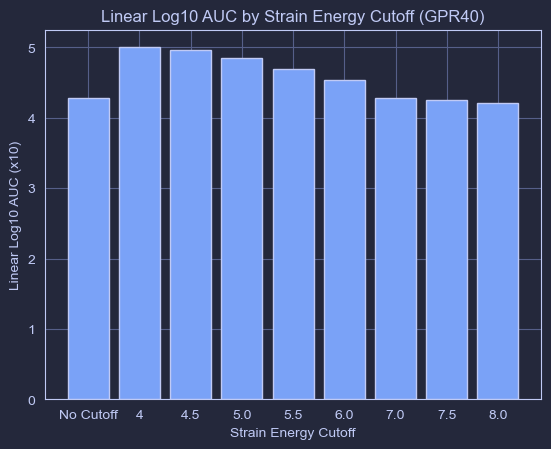

In [22]:
plot_log_aucs(all_data, total_e_thresholds, title_suffix)

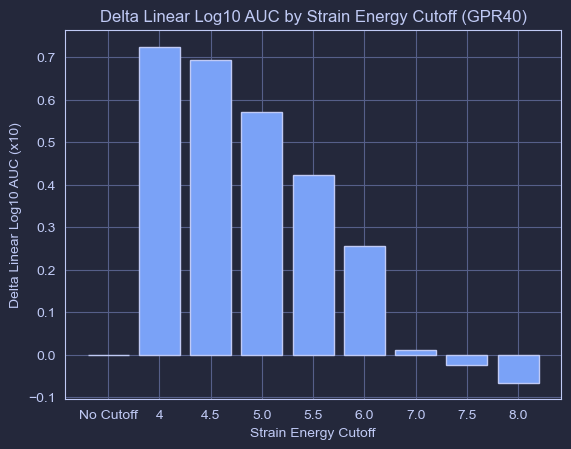

In [23]:
def plot_delta_log_aucs(data, thresholds, title_suffix):
  # Calculate log_auc for 'None' threshold
  none_log_auc = logauc_by_strain(data, total_e_threshold=None)
  
  # Calculate delta log_auc for each threshold and plot
  delta_log_aucs = [logauc_by_strain(data, total_e_threshold=t) - none_log_auc for t in thresholds]
  
  # Create labels for the x-axis
  x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
  
  plt.bar(range(len(thresholds)), delta_log_aucs, tick_label=x_labels)
  plt.title(f"Delta Linear Log10 AUC by Strain Energy Cutoff ({title_suffix})")
  plt.xlabel("Strain Energy Cutoff")
  plt.ylabel("Delta Linear Log10 AUC (x10)")
  plt.show()

plot_delta_log_aucs(all_data, total_e_thresholds, title_suffix)

In [24]:
def write_log_aucs(data, thresholds, title_suffix):
    # Calculate log_auc for each threshold
    log_aucs = [logauc_by_strain(data, total_e_threshold=t) for t in thresholds]

    delta_log_aucs = [0] + [log_aucs[i] - log_aucs[0] for i in range(1, len(log_aucs))]

    #print(f"Delta LogAUCs for {title_suffix}: {delta_log_aucs}")

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]
    
    # Create a dataframe to hold the data
    df = pd.DataFrame({
        "Protein": title_suffix,
        "Strain Energy Cutoff": x_labels,
        "Linear Log10 AUC (x10)": log_aucs,
        "Delta Linear Log10 AUC (x10)": delta_log_aucs
    })
    
    # Write the dataframe to a CSV file
    df.to_csv(f"strain_log_aucs_{title_suffix}.csv", index=False)

write_log_aucs(all_data, total_e_thresholds, title_suffix)

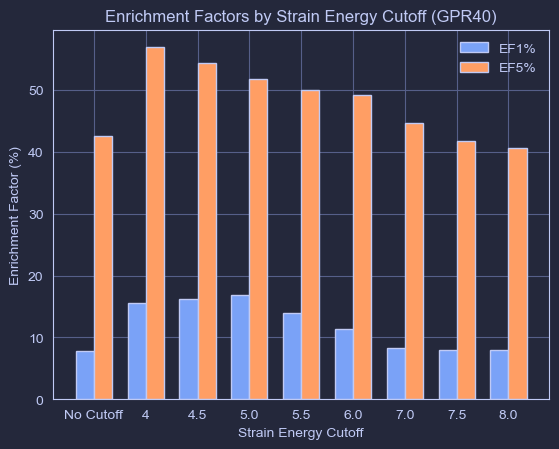

In [25]:
def enrichment_metrics_by_strain(df, total_e_threshold=None):

    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]) * 100

    # print(df.shape)

    # print(
    #     f"1% Closest Cumulative_Actives: {closest_to_one_percent['Cumulative_Actives'].values[0]}"
    # )
    # print(
    #     f"1% Closest Total_Actives: {closest_to_one_percent['Total_Actives'].values[0]}"
    # )
    # print(
    #     f"5% Closest Cumulative_Actives: {closest_to_five_percent['Cumulative_Actives'].values[0]}"
    # )
    # print(
    #     f"5% Closest Total_Actives: {closest_to_five_percent['Total_Actives'].values[0]}"
    # )

    return ef1, ef5


def bar_plot_enrichment_by_strain(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(*[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds])

    # print(f"EF1% for {title_suffix}: {ef1s}")
    # print(f"EF5% for {title_suffix}: {ef5s}")

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create an array with the positions of each bar on the x axis
    x = np.arange(len(x_labels))

    # Set the width of the bars
    bar_width = 0.35

    plt.bar(x - bar_width/2, ef1s, bar_width, label="EF1%")
    plt.bar(x + bar_width/2, ef5s, bar_width, label="EF5%")
    plt.title(f"Enrichment Factors by Strain Energy Cutoff ({title_suffix})")
    plt.xlabel("Strain Energy Cutoff")
    plt.ylabel("Enrichment Factor (%)")
    plt.xticks(x, x_labels)  # Set the position and labels of the xticks
    plt.legend()
    plt.show()

bar_plot_enrichment_by_strain(all_data, total_e_thresholds, title_suffix)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_9682/2506411786.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


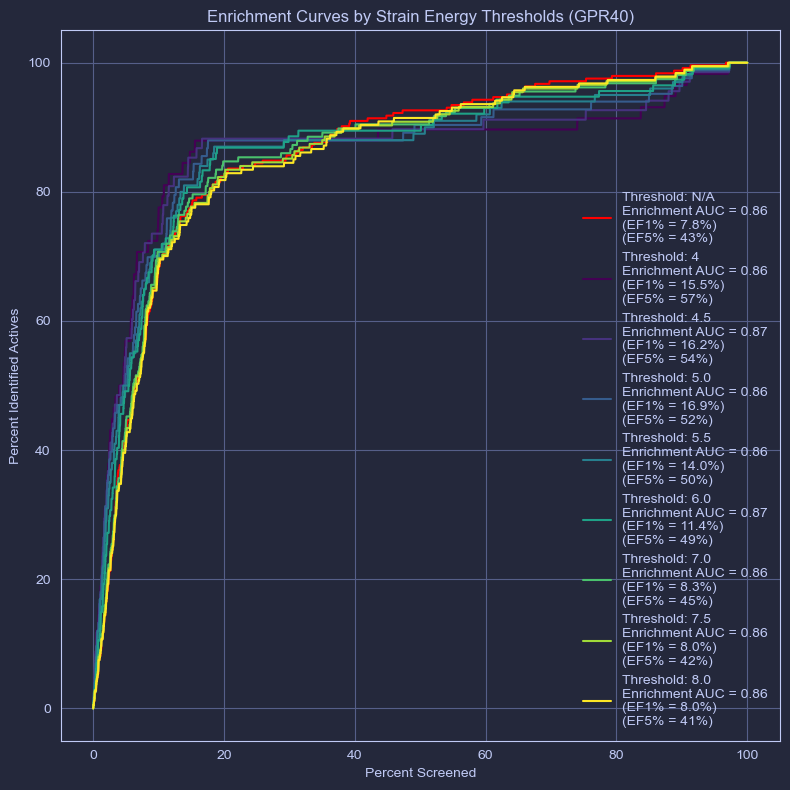

In [26]:
def plot_enrichment_curve_by_strain(df, total_e_threshold=None, ax=None, color='blue'):

    if total_e_threshold is not None:
        df = df[df["Total_E"] <= total_e_threshold]

    df = calculate_enrichment_parameters(df).copy()

    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]

    ef1 = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    ) * 100

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    ef5 = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    ) * 100

    # Plot the enrichment curve
    ax.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Threshold: {}\nEnrichment AUC = {:.2f}\n(EF1% = {:.1f}%)\n(EF5% = {:.0f}%)".format(
            total_e_threshold if total_e_threshold is not None else 'N/A',
            enrichment_auc, ef1, ef5
            ),
        color=color
        )

    # # Add axis labels and title
    # plt.xlabel("Compounds Screened (%)")
    # plt.ylabel("Percent of Identified Actives (%)")
    # plt.title(f"Enrichment Curve ({title_suffix})")

    ax.legend()


def plot_enrichment_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(
        figsize=(8, 8)
        )

    # Define a colormap
    cmap = cm.get_cmap(
        "viridis", len(thresholds) - 1
    )  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Set a distinct color for the first threshold
        color = (
            "red" if t is None else cmap(i - 1)
        )  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_enrichment_curve_by_strain(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Enrichment Curves by Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("Percent Screened")
    ax.set_ylabel("Percent Identified Actives")

    plt.tight_layout()
    plt.show()

plot = plot_enrichment_all_thresholds(all_data, total_e_thresholds, title_suffix)

In [27]:
def write_enrichment_metrics(data, thresholds, title_suffix):
    # Calculate enrichment for each threshold
    ef1s, ef5s = zip(*[enrichment_metrics_by_strain(data, total_e_threshold=t) for t in thresholds])

    # Create labels for the x-axis
    x_labels = [str(t) if t is not None else 'No Cutoff' for t in thresholds]

    # Create a dataframe to hold the data
    df = pd.DataFrame({
        "Protein": title_suffix,
        "Strain Energy Cutoff": x_labels,
        "EF1%": ef1s,
        "EF5%": ef5s
    })

    # Write the dataframe to a CSV file
    df.to_csv(f"strain_enrichment_metrics_{title_suffix}.csv", index=False)

write_enrichment_metrics(all_data, total_e_thresholds, title_suffix)

In [28]:
def plot_semi_log_roc(df, a=1e-3, total_e_threshold=None, ax=None, color='blue'):
  # Filter dataframe based on 'Total_E' threshold if provided
  if total_e_threshold is not None:
    df = df[df["Total_E"] <= total_e_threshold]

  # Invert scores since lower scores indicate positive class
  y_scores_inverted = -df["r_i_docking_score"]

  # Calculate FPR, TPR, and thresholds using sklearn
  fpr, tpr, _ = roc_curve(df["Activity"], y_scores_inverted)

  # Select the thresholds that result in FPR >= a for log scale plotting
  valid_indices = np.where(fpr >= a)
  fpr_valid = fpr[valid_indices]
  tpr_valid = tpr[valid_indices]

  # Calculate log of FPR for valid indices
  log_fpr_valid = np.log10(fpr_valid)

  # Calculate LogAUC
  log_auc = (auc(log_fpr_valid, tpr_valid) / -np.log10(a)) * 10

  # Count the number of rows with Activity = 1 and the total number of rows
  activity_1_count = df[df["Activity"] == 1].shape[0]
  total_count = df.shape[0]

  # Plot semi-log ROC curve
  ax.plot(
    log_fpr_valid,
    tpr_valid,
    label=f"Threshold: {total_e_threshold if total_e_threshold is not None else 'N/A'}, LogAUC: {log_auc:.2f}, Actives: {activity_1_count}, Total count: {total_count}",
    color=color
  )
  ax.legend()


In [29]:
def plot_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set

    # Plot semi-log ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Filter dataframe based on 'Total_E' threshold
        df_filtered = data if t is None else data[data["Total_E"] <= t]

        # Set a distinct color for the first threshold
        color = 'red' if t is None else cmap(i - 1)  # Subtract 1 because the first color is manually set

        # Call the function with the filtered data
        plot_semi_log_roc(df_filtered, total_e_threshold=t, ax=ax, color=color)

    ax.set_title(f"Strain Energy Thresholds ({title_suffix})")
    ax.set_xlabel("log(FPR)")
    ax.set_ylabel("TPR")

    plt.tight_layout()
    plt.show()

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_9682/2145919082.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set


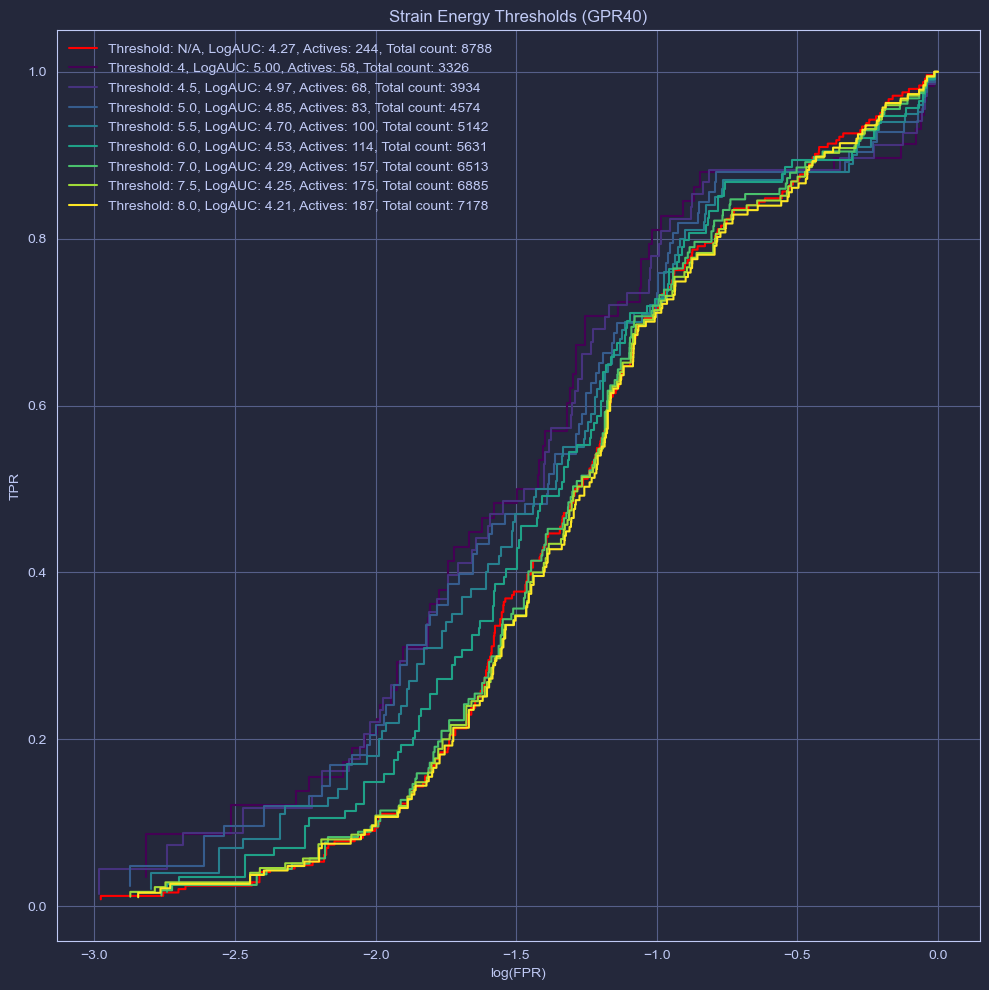

In [30]:
plot = plot_all_thresholds(all_data, total_e_thresholds, title_suffix)

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_9682/2191446731.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set


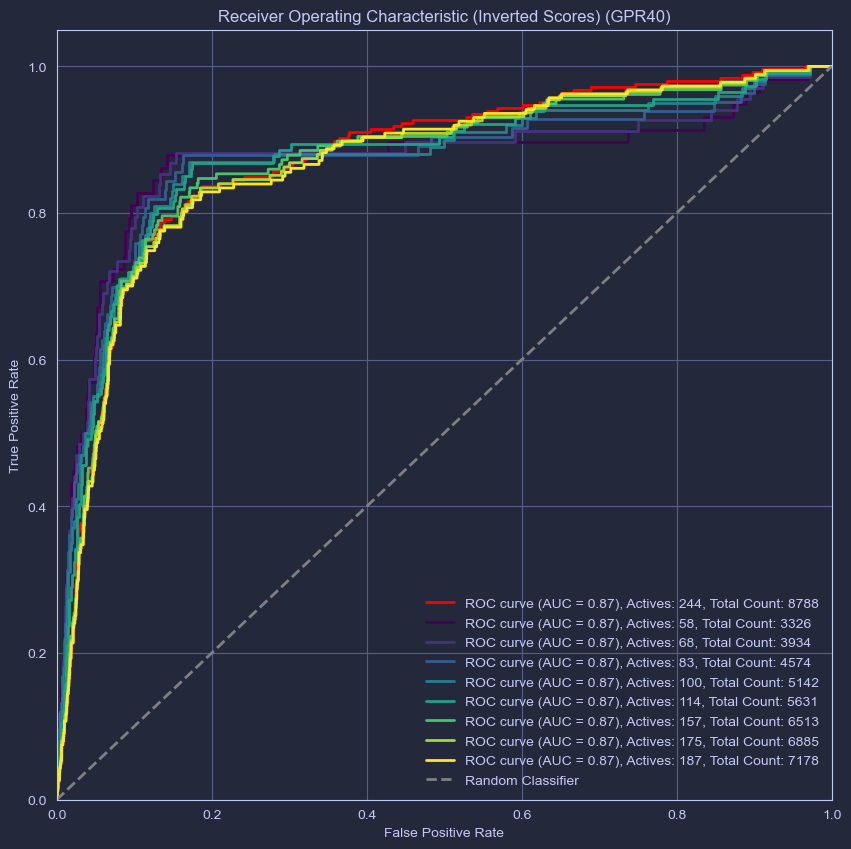

In [31]:
def plot_roc_curve_inverted(data, total_e_threshold, ax, title_suffix, color='blue'):
    """
    Plot the ROC curve for the given true labels and inverted scores.

    :param data: The DataFrame containing the data.
    :param total_e_threshold: The threshold for the 'Total_E' column. If this is not None, the data is filtered to only include rows where 'Total_E' is less than or equal to this threshold.
    :param ax: The axes object to plot on.
    :param title_suffix: The suffix to add to the title of the plot.
    :param color: The color to use for the ROC curve.
    """
    # Filter the data based on 'Total_E' threshold
    df = data if total_e_threshold is None else data[data["Total_E"] <= total_e_threshold]

    # Get the true labels and scores
    y_true = df["Activity"]
    y_scores = df["r_i_docking_score"]

    # Inverting the scores
    y_scores_inverted = -y_scores

    # Compute the ROC curve and AUC with inverted scores
    fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
    roc_auc = auc(fpr, tpr)

    # Count the number of rows with Activity = 1 and the total number of rows
    activity_1_count = df[df["Activity"] == 1].shape[0]
    total_count = df.shape[0]

    # Plotting the ROC curve
    ax.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.2f}), Actives: {activity_1_count}, Total Count: {total_count}", color=color)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"Receiver Operating Characteristic (Inverted Scores) ({title_suffix})")

def plot_roc_curves_all_thresholds(data, thresholds, title_suffix):
    # Create a single plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Define a colormap
    cmap = cm.get_cmap('viridis', len(thresholds) - 1)  # Subtract 1 because the first color is manually set

    # Plot ROC curve for each threshold
    for i, t in enumerate(thresholds):
        # Set a distinct color for the first threshold
        color = 'red' if t is None else cmap(i - 1)  # Subtract 1 because the first color is manually set

        plot_roc_curve_inverted(
            data,
            total_e_threshold=t,
            ax=ax,
            title_suffix=title_suffix,
            color=color
        )

    # Plot the random classifier line after all the ROC curves
    ax.plot([0, 1], [0, 1], lw=2, linestyle="--", label="Random Classifier", color="grey")

    ax.legend()

    plt.show()

plot_roc_curves_all_thresholds(all_data, total_e_thresholds, title_suffix)

In [32]:
def write_roc_metrics(data, thresholds, title_suffix):
    # Create a list to hold the data
    data_list = []

    # Loop over each threshold
    for t in thresholds:
        # Filter the data based on 'Total_E' threshold
        df = data if t is None else data[data["Total_E"] <= t]

        # Get the true labels and scores
        y_true = df["Activity"]
        y_scores = df["r_i_docking_score"]

        # Inverting the scores
        y_scores_inverted = -y_scores

        # Compute the ROC curve and AUC with inverted scores
        fpr, tpr, thresholds = roc_curve(y_true, y_scores_inverted)
        roc_auc = auc(fpr, tpr)

        # Count the number of rows with Activity = 1 and the total number of rows
        activity_1_count = df[df["Activity"] == 1].shape[0]
        total_count = df.shape[0]

        # Add the data to the list
        data_list.append({
            "Protein": title_suffix,
            "Strain Energy Cutoff": t if t is not None else 'No Cutoff',
            "ROC_AUC": roc_auc,
            "Actives": activity_1_count,
            "Total Count": total_count
        })

    # Create a dataframe from the list
    df = pd.DataFrame(data_list)

    # Write the dataframe to a CSV file
    df.to_csv(f"strain_roc_metrics_{title_suffix}.csv", index=False)

write_roc_metrics(all_data, total_e_thresholds, title_suffix)

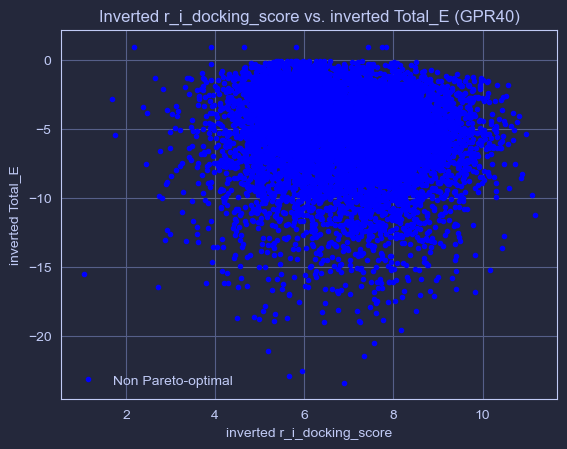

In [33]:
import oapackage

df = all_data

# Invert the scores for optimization
df["inverted_docking_score"] = -df["r_i_docking_score"]
df["inverted_Total_E"] = -df["Total_E"]

df.dropna(subset=['inverted_docking_score', 'inverted_Total_E'], inplace=True)

plt.plot(
    df["inverted_docking_score"],
    df["inverted_Total_E"],
    ".b",
    label="Non Pareto-optimal",
)
plt.title(f"Inverted r_i_docking_score vs. inverted Total_E ({title_suffix})")
plt.xlabel("inverted r_i_docking_score")
plt.ylabel("inverted Total_E")
plt.legend()
plt.show()

Pareto: 17 optimal values, 17 objects


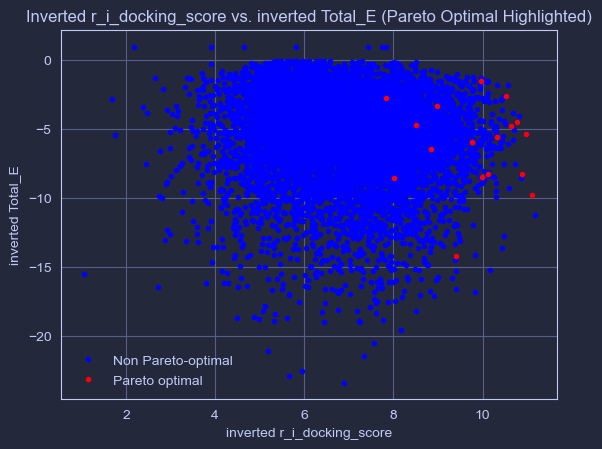

In [34]:
pareto = oapackage.ParetoDoubleLong()

# Use the inverted scores for Pareto optimization
for index, row in df.iterrows():
    w = oapackage.doubleVector((row["inverted_docking_score"], row["inverted_Total_E"]))
    pareto.addvalue(w, index)

pareto.show(verbose=1)
# Retrieve the indices of Pareto optimal points
lst = pareto.allindices()

# Convert the list of indices to a format suitable for DataFrame indexing
index_list = [int(x) for x in lst]  # Ensure indices are in integer format

# Select Pareto optimal points from the DataFrame using the corrected indices
optimal_datapoints = df.iloc[index_list]

# Re-plot the initial data for context
plt.plot(
    df["inverted_docking_score"],
    df["inverted_Total_E"],
    ".b",
    label="Non Pareto-optimal",
)

# Plot Pareto optimal points
plt.plot(
    optimal_datapoints["inverted_docking_score"],
    optimal_datapoints["inverted_Total_E"],
    ".r",
    label="Pareto optimal",
)

plt.title(
    f"Inverted r_i_docking_score vs. inverted Total_E (Pareto Optimal Highlighted)"
)
plt.xlabel("inverted r_i_docking_score")
plt.ylabel("inverted Total_E")
plt.legend()
plt.show()

In [35]:
display(optimal_datapoints)

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened,inverted_docking_score,inverted_Total_E
2,TAK-875_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x16fcee7a0>,1,GPR40_chembl19_set_active_sc.smi,246,53161,0,S-OPLS,32.6087,1,TAK-875_Isomer2-1,GPR40,245,11,-11.10010,-0.300002,-0.999675,-2.40735,-11.1001,-5.53916,-0.524851,-0,-1.01411,-46.0319,-15.4161,0.675266,-0.0832139,-109.415,-61.448,11.2322,96,372,0,9.807528,8.486209,NaN,3.0,1,244,0.004098,0.000228,11.10010,-9.807528
3,C13171061_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x289405700>,0,GPR40_chembl19_set_decoy_sc.smi,6865,53161,0,S-OPLS,21.913,1,C13171061_Isomer1-1,GPR40,6864,4,-10.97510,-0.522624,-1.44188,-2.71357,-10.9751,-4.05428,-0.567157,-0,-3.5067,-39.9828,-6.39998,0.212161,-0.1,-84.7868,-46.3828,5.44159,6,47,0,5.343651,4.752094,6.319433,1.0,1,244,0.004098,0.000341,10.97510,-5.343651
4,C16913079_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x289405850>,0,GPR40_chembl19_set_decoy_sc.smi,6153,53161,0,S-OPLS,58.1713,1,C16913079_Isomer1-1,GPR40,6152,9,-10.87830,-0.329644,-1.05734,-2.41927,-10.8783,-5.12699,-0.302779,-0,-2.97422,-40.4294,-4.94366,0.3219,-0.0331467,-52.6123,-45.373,13.7545,52,17,0,8.276522,7.469264,inf,0.0,1,244,0.004098,0.000455,10.87830,-8.276522
7,C41515253_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2894057e0>,0,GPR40_chembl19_set_decoy_sc.smi,6274,53161,0,S-OPLS,39.7094,1,C41515253_Isomer1-1,GPR40,6273,4,-10.78100,-0.490044,-1.37312,-2.63526,-10.781,-4.68563,-0.554589,-0,-3.48139,-26.7115,-7.94071,0.567332,-0.1,-66.9569,-34.6522,2.90965,22,368,0,4.513020,3.795396,5.668027,0.0,2,244,0.008197,0.000797,10.78100,-4.513020
12,CHEMBL2022244_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x16fceeb20>,1,GPR40_chembl19_set_active_sc.smi,53,53161,0,S-OPLS,42.9199,1,CHEMBL2022244_Isomer1-1,GPR40,52,7,-10.65010,-0.355004,-1.10308,-2.41982,-10.6501,-6.13685,-0.311111,-0,-1.57834,-44.2312,-5.61931,0.513323,-0.0826683,-80.7631,-49.8505,1.78817,118,288,0,4.740483,4.282185,5.304399,5.0,3,244,0.012295,0.001365,10.65010,-4.740483
16,C37088849_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x289405a10>,0,GPR40_chembl19_set_decoy_sc.smi,2579,53161,0,S-OPLS,36.1255,1,C37088849_Isomer1-1,GPR40,2578,4,-10.53690,-0.526844,-1.43008,-2.63703,-10.5369,-4.39141,-0.390067,-0,-3.09768,-26.8218,-10.637,0.34906,-0.0701405,-65.2436,-37.4588,7.23037,3,91,0,2.626851,2.230261,3.203992,3.0,3,244,0.012295,0.001821,10.53690,-2.626851
33,C63004522_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x289406180>,0,GPR40_chembl19_set_decoy_sc.smi,5334,53161,0,S-OPLS,26.312,1,C63004522_Isomer1-1,GPR40,5333,4,-10.32530,-0.60737,-1.56172,-2.69364,-10.3253,-3.17449,-0.503915,-0,-4.64796,-26.4083,-6.61492,0.413725,-0.1,-52.5589,-33.0232,13.969,2,240,0,5.597951,4.915898,inf,2.0,6,244,0.024590,0.003755,10.32530,-5.597951
61,C71392493_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x289406b20>,0,GPR40_chembl19_set_decoy_sc.smi,1051,53161,0,S-OPLS,23.3929,1,C71392493_Isomer1-1,GPR40,1050,8,-10.12200,-0.506101,-1.37377,-2.53321,-10.122,-4.13587,-0.429157,-0,-3.72733,-34.6267,-5.01536,0.728246,-0.0742618,-70.7656,-39.6421,13.0177,5,87,0,8.232117,7.610771,9.123363,2.0,12,244,0.049180,0.006941,10.12200,-8.232117
80,CHEMBL2022257_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x16fcef220>,1,GPR40_chembl19_set_active_sc.smi,59,53161,0,S-OPLS,35.5205,1,CHEMBL2022257_Isomer1-1,GPR40,58,7,-9.99526

In [36]:
from paretoset import paretoset

subset_df = df[["inverted_docking_score", "inverted_Total_E"]]

subset_df.dropna(subset=["inverted_docking_score", "inverted_Total_E"], inplace=True)

mask = paretoset(subset_df, sense=["max", "max"])
paretoset_subset = subset_df[mask]

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_9682/1772348083.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.dropna(subset=["inverted_docking_score", "inverted_Total_E"], inplace=True)


In [37]:
subset_df.describe()


,inverted_docking_score,inverted_Total_E
count,8769.000000,8769.000000
mean,6.895095,-5.388126
std,1.413623,3.179087
min,1.053810,-23.394901
25%,5.772090,-7.093540
50%,6.910620,-4.860207
75%,8.000850,-3.065440
max,11.171700,1.000000


In [38]:
# Check for NaN values in each column
nan_count_column1 = subset_df["inverted_docking_score"].isna().sum()
nan_count_column2 = subset_df["inverted_Total_E"].isna().sum()

print(f"NaN count in column1: {nan_count_column1}")
print(f"NaN count in column2: {nan_count_column2}")

NaN count in column1: 0
NaN count in column2: 0


In [39]:
nan_rows = all_data[all_data['inverted_Total_E'].isna()]
display(nan_rows)

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened,inverted_docking_score,inverted_Total_E


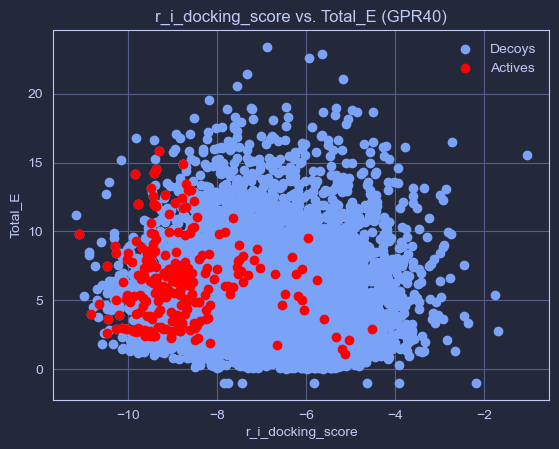

In [40]:
plt.scatter(all_data["r_i_docking_score"], all_data["Total_E"])
actives_all_data = all_data[all_data["Activity"] == 1]
plt.scatter(actives_all_data["r_i_docking_score"], actives_all_data["Total_E"], c="red")
plt.title(f"r_i_docking_score vs. Total_E ({title_suffix})")
plt.xlabel("r_i_docking_score")
plt.ylabel("Total_E")
plt.legend(["Decoys", "Actives"])
plt.show()

In [41]:
all_data_NegativeStrain=all_data[all_data["Total_E"] <= 0]
all_data_NegativeStrain

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened,inverted_docking_score,inverted_Total_E
2536,C13278939_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28c61da10>,0,GPR40_chembl19_set_decoy_sc.smi,1113,53161,0,S-OPLS,26.8316,1,C13278939_Isomer1-1,GPR40,1112,6,-7.84442,-0.326851,-0.9428,-1.87753,-7.84442,-4.05483,0,-0,-2.124,-37.5891,-1.22468,0.397575,0,-61.716,-38.8137,2.69061,1,150,0,-1.0,0.0,0.0,1.0,207,244,0.848361,0.288575,7.84442,1.0
2719,C57312931_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28c65e9d0>,0,GPR40_chembl19_set_decoy_sc.smi,3106,53161,0,S-OPLS,37.4679,1,C57312931_Isomer1-1,GPR40,3105,6,-7.75270,-0.287137,-0.861411,-1.8047,-7.7527,-3.91875,-0.109502,-0,-2.13911,-37.4514,-1.88471,0.569936,0,-56.4722,-39.3362,4.76996,14,171,0,-1.0,0.0,0.0,0.0,209,244,0.856557,0.309399,7.75270,1.0
3424,C32943102_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x28d1a1c40>,0,GPR40_chembl19_set_decoy_sc.smi,425,53161,0,S-OPLS,46.6835,1,C32943102_Isomer1-1,GPR40,424,8,-7.43163,-0.256263,-0.787322,-1.70166,-7.43163,-4.00517,0,-0,-1.58784,-44.3684,-1.43486,0.595032,0,-60.8441,-45.8033,8.64095,31,141,0,-1.0,0.0,0.0,1.0,220,244,0.901639,0.389622,7.43163,1.0
6470,C68576332_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2a84ed540>,0,GPR40_chembl19_set_decoy_sc.smi,7555,53161,0,S-OPLS,52.22,1,C68576332_Isomer1-1,GPR40,7554,8,-5.81892,-0.207819,-0.631059,-1.34318,-5.81892,-2.6255,0,-0,-2.02404,-33.1367,-0.706081,0.593365,0,-44.8491,-33.8428,3.16984,118,283,0,-1.0,0.0,0.0,2.0,237,244,0.971311,0.736231,5.81892,1.0
8436,C78535920_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ad02f5a0>,0,GPR40_chembl19_set_decoy_sc.smi,3573,53161,0,S-OPLS,41.3707,1,C78535920_Isomer1-1,GPR40,3572,6,-4.63738,-0.21079,-0.590641,-1.13354,-4.63738,-2.25783,0,-0,-1.55714,-27.1391,-0.924398,0.673206,0,-35.6303,-28.0635,1.56919,5,249,0,-1.0,0.0,0.0,2.0,243,244,0.995902,0.959945,4.63738,1.0
8687,C33813799_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ad0ae420>,0,GPR40_chembl19_set_decoy_sc.smi,892,53161,0,S-OPLS,37.719,1,C33813799_Isomer1-1,GPR40,891,4,-3.91010,-0.162921,-0.469945,-0.935866,-3.9101,-2.16993,0,-0,-0.754325,-27.2102,0.162007,0.35036,0,-30.2231,-27.0481,6.43088,1,232,0,-1.0,0.0,0.0,1.0,244,244,1.000000,0.988507,3.91010,1.0
8785,C14034419_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ad0ed070>,0,GPR40_chembl19_set_decoy_sc.smi,3471,53161,0,S-OPLS,50.937,1,C14034419_Isomer1-1,GPR40,3470,12,-2.18339,-0.0682309,-0.216619,-0.48892,-2.18339,-2.71001,0,-0,1.4196,-33.8333,-0.171843,0.824463,0,-30.7283,-34.0051,16.3288,218,214,0,-1.0,0.0,0.0,4.0,244,244,1.000000,0.999659,2.18339,1.0


In [42]:
# print Molecule_Name for all rows with Total_E <= 0
for index, row in all_data_NegativeStrain.iterrows():
    print(row['Molecule_Name'])

C13278939_Isomer1
C57312931_Isomer1
C32943102_Isomer1
C68576332_Isomer1
C78535920_Isomer1
C33813799_Isomer1
C14034419_Isomer1


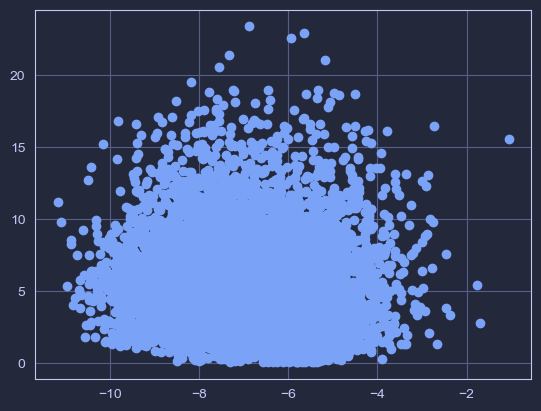

In [43]:
all_data_positive = all_data[all_data["Total_E"] >= 0]
plt.scatter(all_data_positive["r_i_docking_score"], all_data_positive["Total_E"])

In [44]:
all_data_positive.to_csv(f"all_data_positive_{title_suffix}.csv", index=False)

In [45]:
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

In [46]:
def identify_pareto(scores):
    population_size = scores.shape[0]
    pareto_front = np.ones(population_size, dtype=bool)
    for i in range(population_size):
        for j in range(population_size):
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
                pareto_front[i] = 0
                break
    return np.where(pareto_front == 1)[0]


def find_pareto_ranks(scores, max_ranks=100):
    ranks = []
    remaining_scores = scores.copy()
    remaining_indices = np.arange(scores.shape[0])
    for _ in range(max_ranks):
        pareto_indices = identify_pareto(remaining_scores)
        ranks.append(remaining_indices[pareto_indices])
        remaining_scores = np.delete(remaining_scores, pareto_indices, axis=0)
        remaining_indices = np.delete(remaining_indices, pareto_indices)
        if remaining_scores.shape[0] == 0:
            break
    return ranks



In [47]:
data = all_data_positive

In [48]:
# Extract the scores for the entire dataset
scores = data[["r_i_docking_score", "Total_E"]].values

# Find the ranks of Pareto fronts until all points are classified or a max limit is reached
pareto_ranks_indices = find_pareto_ranks(
    scores, max_ranks=20
)  # Adjust max_ranks as needed

/var/folders/2c/b9b_8fbs13j5zcz4wv9bqqjm0000gn/T/ipykernel_9682/1624393553.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, num_ranks - 1, num_ranks))


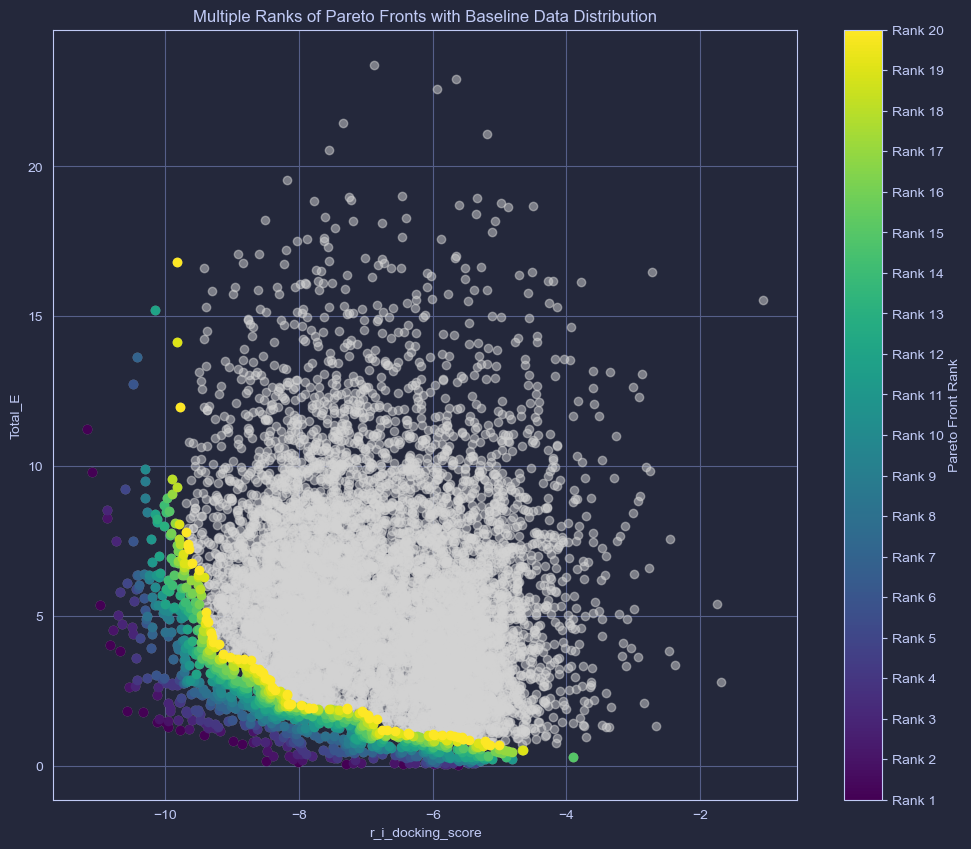

In [49]:
# Determine the actual number of ranks found
num_ranks = len(pareto_ranks_indices)

# Plot the baseline data distribution
plt.figure(figsize=(12, 10))
plt.scatter(
    data["r_i_docking_score"],
    data["Total_E"],
    color="lightgrey",
    label="Baseline Data",
    alpha=0.5,
)

# Generate colors for each rank dynamically using a colormap
colormap = viridis
norm = Normalize(vmin=0, vmax=num_ranks - 1)

for i, indices in enumerate(pareto_ranks_indices):
    rank_data = data.iloc[indices]
    plt.scatter(
        rank_data["r_i_docking_score"],
        rank_data["Total_E"],
        color=colormap(norm(i)),
        label=f"Rank {i+1}",
    )

plt.title("Multiple Ranks of Pareto Fronts with Baseline Data Distribution")
plt.xlabel("r_i_docking_score")
plt.ylabel("Total_E")

# Create a custom legend
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, num_ranks - 1, num_ranks))
cbar.ax.set_yticklabels([f"Rank {i+1}" for i in range(num_ranks)])
cbar.set_label("Pareto Front Rank")

plt.grid(True)
plt.show()

In [50]:
# Count the number of Pareto points per rank and the total
num_points_per_rank = [len(indices) for indices in pareto_ranks_indices]
total_points = sum(num_points_per_rank)

# Print the counts
print("Number of Pareto points per rank:")
for rank, count in enumerate(num_points_per_rank, start=1):
    print(f"Rank {rank}: {count} points")

print(f"\nTotal Pareto points across all ranks: {total_points}")

Number of Pareto points per rank:
Rank 1: 19 points
Rank 2: 20 points
Rank 3: 30 points
Rank 4: 33 points
Rank 5: 33 points
Rank 6: 31 points
Rank 7: 42 points
Rank 8: 37 points
Rank 9: 46 points
Rank 10: 46 points
Rank 11: 52 points
Rank 12: 55 points
Rank 13: 50 points
Rank 14: 54 points
Rank 15: 65 points
Rank 16: 54 points
Rank 17: 56 points
Rank 18: 50 points
Rank 19: 59 points
Rank 20: 64 points

Total Pareto points across all ranks: 896


In [51]:
all_pareto_ranks_indices = np.concatenate(pareto_ranks_indices)
display(data.iloc[all_pareto_ranks_indices])

,Molecule_Name,Mol,Activity,s_m_source_file,i_m_source_file_index,i_lp_mmshare_version,i_f3d_flags,s_lp_Force_Field,r_lp_Energy,b_lp_Chiralities_Consistent,s_lp_Variant,s_i_glide_gridfile,i_i_glide_lignum,i_i_glide_rotatable_bonds,r_i_docking_score,r_i_glide_ligand_efficiency,r_i_glide_ligand_efficiency_sa,r_i_glide_ligand_efficiency_ln,r_i_glide_gscore,r_i_glide_lipo,r_i_glide_hbond,r_i_glide_metal,r_i_glide_rewards,r_i_glide_evdw,r_i_glide_ecoul,r_i_glide_erotb,r_i_glide_esite,r_i_glide_emodel,r_i_glide_energy,r_i_glide_einternal,i_i_glide_confnum,i_i_glide_posenum,r_i_glide_eff_state_penalty,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns,Cumulative_Actives,Total_Actives,Fraction_Actives,Percentage_Screened,inverted_docking_score,inverted_Total_E
1,C03095174_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2894055b0>,0,GPR40_chembl19_set_decoy_sc.smi,8178,53161,0,S-OPLS,57.1172,1,C03095174_Isomer1-1,GPR40,8177,6,-11.17170,-0.37239,-1.1571,-2.53833,-11.1717,-4.5256,-0.479901,-0,-3.22389,-45.9457,-6.19778,0.368657,-0.0840014,-94.3056,-52.1435,18.5623,126,47,0,11.220968,7.912696,NaN,0.0,0,244,0.000000,0.000114,11.17170,-11.220968
2,TAK-875_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x16fcee7a0>,1,GPR40_chembl19_set_active_sc.smi,246,53161,0,S-OPLS,32.6087,1,TAK-875_Isomer2-1,GPR40,245,11,-11.10010,-0.300002,-0.999675,-2.40735,-11.1001,-5.53916,-0.524851,-0,-1.01411,-46.0319,-15.4161,0.675266,-0.0832139,-109.415,-61.448,11.2322,96,372,0,9.807528,8.486209,NaN,3.0,1,244,0.004098,0.000228,11.10010,-9.807528
3,C13171061_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x289405700>,0,GPR40_chembl19_set_decoy_sc.smi,6865,53161,0,S-OPLS,21.913,1,C13171061_Isomer1-1,GPR40,6864,4,-10.97510,-0.522624,-1.44188,-2.71357,-10.9751,-4.05428,-0.567157,-0,-3.5067,-39.9828,-6.39998,0.212161,-0.1,-84.7868,-46.3828,5.44159,6,47,0,5.343651,4.752094,6.319433,1.0,1,244,0.004098,0.000341,10.97510,-5.343651
6,CHEMBL2022244_Isomer2,<rdkit.Chem.rdchem.Mol object at 0x16fcee8f0>,1,GPR40_chembl19_set_active_sc.smi,54,53161,0,S-OPLS,41.3628,1,CHEMBL2022244_Isomer2-1,GPR40,53,7,-10.82520,-0.360841,-1.12122,-2.45961,-10.8252,-6.1066,-0.409078,-0,-1.54142,-42.6813,-9.04436,0.733318,-0.0107346,-80.3613,-51.7256,4.33857,23,156,0,4.016980,3.344857,NaN,2.0,2,244,0.008197,0.000683,10.82520,-4.016980
11,C71379466_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x289405b60>,0,GPR40_chembl19_set_decoy_sc.smi,6085,53161,0,S-OPLS,46.7435,1,C71379466_Isomer1-1,GPR40,6084,6,-10.67430,-0.5083,-1.40236,-2.6392,-10.6743,-3.95903,-0.409632,-0,-4.17192,-31.9929,-6.7789,0.580709,-0.0979416,-77.2762,-38.7718,5.47868,144,18,0,3.808330,3.300956,4.492816,5.0,2,244,0.008197,0.001252,10.67430,-3.808330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293,C71465454_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2aa12bf40>,0,GPR40_chembl19_set_decoy_sc.smi,5884,53161,0,S-OPLS,10.0066,1,C71465454_Isomer1-1,GPR40,5883,0,-5.46068,-0.420053,-0.987684,-1.53177,-5.46068,-2.2244,0,-0,-2.01126,-22.7518,-0.582937,0,0,-31.5292,-23.3347,0,1,199,0,0.838101,0.703233,1.008507,0.0,239,244,0.979508,0.829882,5.46068,-0.838101
7768,C48652777_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ab42d070>,0,GPR40_chembl19_set_decoy_sc.smi,838,53161,0,S-OPLS,27.5913,1,C48652777_Isomer1-1,GPR40,837,3,-5.22315,-0.261158,-0.708891,-1.30718,-5.22315,-2.71028,0,-0,-1.73008,-25.9152,-0.292531,0.556852,0,-34.9227,-26.2077,0.708761,16,220,0,0.821354,0.539629,1.187094,2.0,240,244,0.983607,0.883933,5.22315,-0.821354
7815,C05318430_Isomer1,<rdkit.Chem.rdchem.Mol object at 0x2ab42e500>,0,GPR40_chembl19_set_decoy_sc.smi,4539,53161,0,S-OPLS,26.217,1,C05318430_Isomer1-1,GPR40,4538,4,-5.19065,-0.18538,-0.562924,-1.19815,-5.19065,-3.24018,0,-0,-0.883147,-27.0067,0.235177,0.247741,0,-34.3783,-26.7715,1.14422,1,196,0,0.723757,0.562064,0.897666,3.0,241,244,0.987705,0.889281,5.19065,-0.723757
7885,C55503741_Isomer1,<rdkit.Chem.rdch

In [52]:
pareto_front_df = data.iloc[all_pareto_ranks_indices]

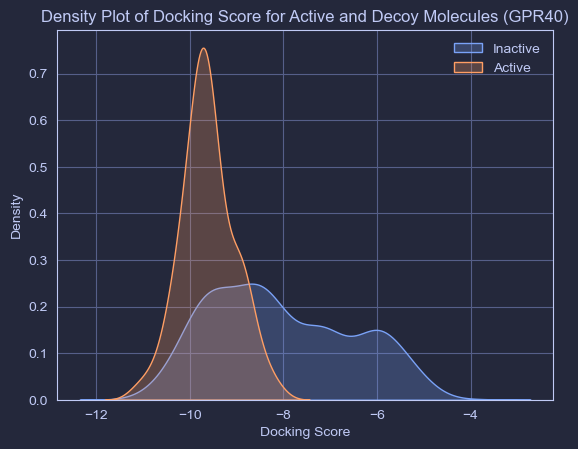

In [53]:
plot_density(pareto_front_df, title_suffix)

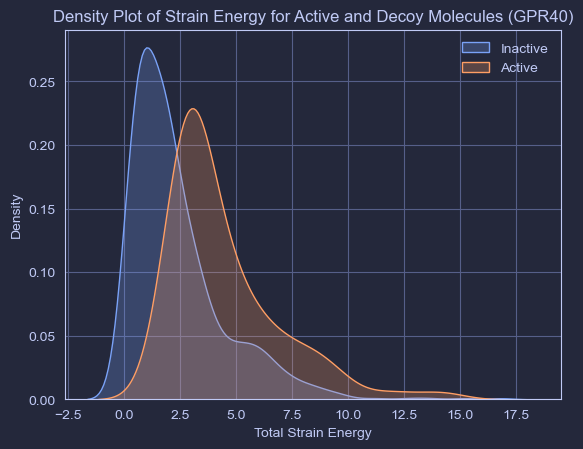

In [54]:
plot_density_strain(pareto_front_df, title_suffix)

In [55]:
pareto_front_df = calculate_enrichment_parameters(pareto_front_df)

In [56]:
def plot_enrichment_curve_classifier(df, title_suffix):
    """
    Plots the enrichment curve for a dataframe, including the performance of a random classifier.

    Parameters:
    df (pandas.DataFrame): The dataframe to plot the enrichment curve for.
    title_suffix (str): The suffix to add to the title of the plot.

    Returns:
    None
    """
    # Calculate the Enrichment AUC
    enrichment_auc = auc(df["Percentage_Screened"], df["Fraction_Actives"])

    # Calculate the enrichment at the closest value to 1%
    # Subtract 0.01 (1%) from the 'Percentage_Screened' column and find the absolute value
    # (df['Percentage_Screened'] - 0.01).abs()
    # Sort the resulting series and take the first index (smallest difference)
    # (df['Percentage_Screened'] - 0.01).abs().argsort()[:1]
    # Use the index to get the row from the dataframe
    closest_to_one_percent = df.iloc[
        (df["Percentage_Screened"] - 0.01).abs().argsort()[:1]
    ]
    # df["Some_Column"].values[0] gets the value of the first row of "Some_Column"
    # It would return a pd.Series without: .values[0]
    enrichment_at_one_percent = (
        closest_to_one_percent["Cumulative_Actives"].values[0]
        / closest_to_one_percent["Total_Actives"].values[0]
    )

    closest_to_five_percent = df.iloc[
        (df["Percentage_Screened"] - 0.05).abs().argsort()[:1]
    ]
    # df["Some_Column"].values[0] gets the value of the first row of "Some_Column"
    # It would return a pd.Series without: .values[0]
    enrichment_at_five_percent = (
        closest_to_five_percent["Cumulative_Actives"].values[0]
        / closest_to_five_percent["Total_Actives"].values[0]
    )

    # Plot the enrichment curve
    plt.plot(
        df["Percentage_Screened"] * 100,
        df["Fraction_Actives"] * 100,
        label="Enrichment AUC = {:.2f}\n(EF1% = {:.1f}%)\n(EF5% = {:.0f}%)".format(
            enrichment_auc,
            enrichment_at_one_percent * 100,
            enrichment_at_five_percent * 100,
        ),
    )

    #   # Plot the enrichment at 1%
    #   plt.scatter(
    #   1,
    #   enrichment_at_one_percent * 100,
    #   s=0,
    #   color='black',
    #   label="Enrichment (%) at 1% = {:.2f}".format(enrichment_at_one_percent*100),
    # )

    # Calculate and plot the performance of a random classifier
    overall_fraction_actives = df["Fraction_Actives"].iloc[
        -1
    ]  # Assuming the last point represents the overall fraction
    plt.plot(
        [0, 100],
        [0, overall_fraction_actives * 100],
        label="Random Classifier",
        linestyle="--",
        color="grey",
    )

    # Add axis labels and title
    plt.xlabel("Compounds Screened (%)")
    plt.ylabel("Percent of Identified Actives (%)")
    plt.title(f"Enrichment Curve ({title_suffix})")

    plt.legend()
    plt.show()


In [57]:
threshold4 = all_data[all_data["Total_E"] <= 4]
threshold4 = calculate_enrichment_parameters(threshold4)

In [58]:
import matplotx
plt.style.use(matplotx.styles.tokyo_night["storm"])

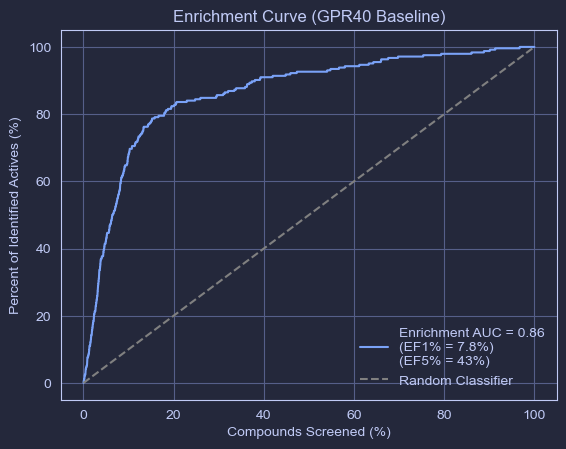

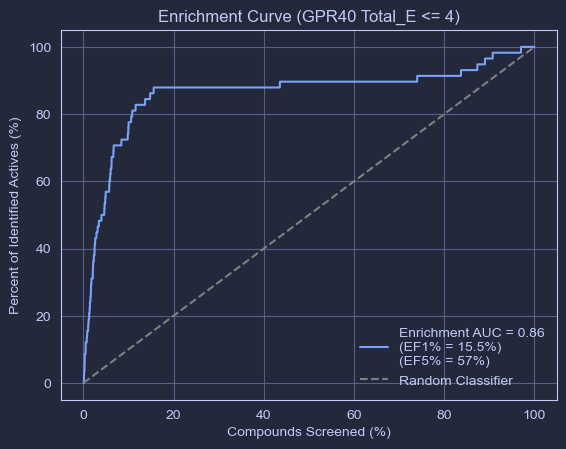

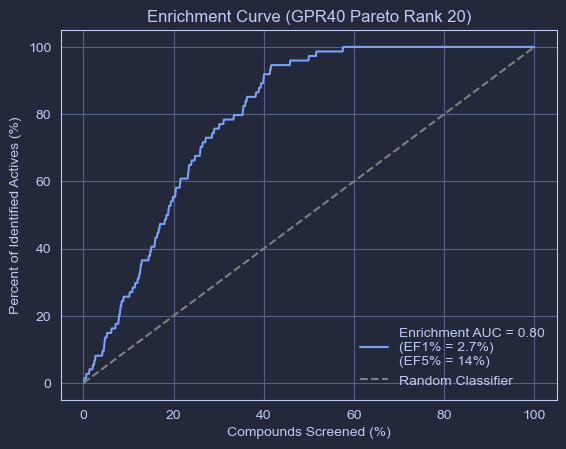

In [60]:
plot_enrichment_curve_classifier(all_data, "GPR40 Baseline")
plot_enrichment_curve_classifier(threshold4, "GPR40 Total_E <= 4")
plot_enrichment_curve_classifier(pareto_front_df, "GPR40 Pareto Rank 20")